# Métricas de interacción 
## Introducción

En este proyecto, analizaremos el comportamiento de los usuarios de una aplicación de una empresa emergente que vende productos alimenticios. El objetivo es comprender cómo interactúan los usuarios con la aplicación, especialmente en términos del embudo de ventas, y evaluar los resultados de un experimento A/A/B para determinar el impacto de un cambio de diseño en la interfaz de la aplicación.

En la primera parte del análisis, exploraremos el embudo de ventas, que describe el proceso por el cual los usuarios pasan desde su primer contacto con la aplicación hasta la etapa final de compra. Evaluaremos cuántos usuarios logran llegar a la etapa de compra, y cuántos abandonan el proceso en etapas anteriores. Identificaremos las etapas donde se pierden más usuarios y proporcionaremos recomendaciones basadas en estos hallazgos.

En la segunda parte del proyecto, analizaremos los resultados de un experimento A/A/B. En este experimento, los usuarios se dividen en tres grupos: dos grupos de control que mantienen el diseño original de la aplicación, y un grupo de prueba que recibe un nuevo diseño de fuentes. El objetivo del experimento es determinar si el cambio en el diseño tiene un impacto significativo en el comportamiento de los usuarios. Al comparar los resultados entre los grupos de control y el grupo de prueba, evaluaremos si el nuevo diseño debe ser adoptado o si podría resultar en una experiencia de usuario menos favorable.

El análisis se llevará a cabo utilizando Python y Jupyter Notebook, aprovechando bibliotecas como pandas para la manipulación de datos y scipy para las pruebas estadísticas. Este enfoque nos permitirá tomar decisiones informadas sobre el diseño de la aplicación y mejorar la experiencia de usuario en función de los datos observados.

## Abrir el archivo de datos y leer la información general


In [1]:
# Cargar las librerias que vamos a usar
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency

In [2]:
# Cargar el archivo de datos
ruta_archivo = '/datasets/logs_exp_us.csv'
data = pd.read_csv(ruta_archivo, sep='\t')

# Mostrar las primeras filas del dataframe
print(data.head())

# Información general del dataframe
print(data.info())

                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None


## Preparar los datos para el análisis


In [3]:
# Cambiar los nombres de las columnas
data.columns = ['event_name', 'user_id', 'event_timestamp', 'exp_id']

# Comprobar si hay valores ausentes
print(data.isnull().sum())

# Convertir event_timestamp a datetime
data['event_datetime'] = pd.to_datetime(data['event_timestamp'], unit='s')

# Crear una columna separada para las fechas
data['event_date'] = data['event_datetime'].dt.date

# Ver los primeros registros para comprobar
print(data.head())

# Verificar la información general del DataFrame
data.info()

event_name         0
user_id            0
event_timestamp    0
exp_id             0
dtype: int64
                event_name              user_id  event_timestamp  exp_id  \
0         MainScreenAppear  4575588528974610257       1564029816     246   
1         MainScreenAppear  7416695313311560658       1564053102     246   
2  PaymentScreenSuccessful  3518123091307005509       1564054127     248   
3         CartScreenAppear  3518123091307005509       1564054127     248   
4  PaymentScreenSuccessful  6217807653094995999       1564055322     248   

       event_datetime  event_date  
0 2019-07-25 04:43:36  2019-07-25  
1 2019-07-25 11:11:42  2019-07-25  
2 2019-07-25 11:28:47  2019-07-25  
3 2019-07-25 11:28:47  2019-07-25  
4 2019-07-25 11:48:42  2019-07-25  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_n

- Los nombres de las columnas han sido cambiados a un formato más descriptivo y manejable: event_name, user_id, event_timestamp, exp_id, event_datetime, y event_date.
- No hay valores ausentes en ninguna de las columnas (event_name, user_id, event_timestamp, exp_id). Esto es positivo porque significa que no necesitamos lidiar con datos faltantes en esta etapa, y podemos proceder con el análisis sin tener que limpiar valores nulos.
- Se ha convertido correctamente la columna event_timestamp a un formato de fecha y hora (event_datetime). Además, se ha creado una columna separada para las fechas (event_date). Esto facilitará el análisis basado en el tiempo, como la segmentación de datos por días o el análisis del embudo de ventas a lo largo del tiempo.
- El DataFrame tiene 244,126 registros, y todos los registros tienen valores válidos en todas las columnas, lo que indica que el dataset está completo y listo para un análisis más profundo.
- Las fechas en event_datetime parecen estar en el rango de julio de 2019, lo que será útil para el análisis del periodo cubierto por los datos.

## Estudiar y comprobar los datos
### ¿Cuántos eventos hay en los registros?

In [4]:
# Número total de eventos
total_events = data.shape[0]
print(f"Total de eventos: {total_events}")

Total de eventos: 244126


### ¿Cuántos eventos hay en los registros?

In [5]:
# Número de usuarios únicos
unique_users = data['user_id'].nunique()
print(f"Total de usuarios únicos: {unique_users}")

Total de usuarios únicos: 7551


### ¿Cuál es el promedio de eventos por usuario?

In [6]:
# Promedio de eventos por usuario
avg_events_per_user = total_events / unique_users
print(f"Promedio de eventos por usuario: {avg_events_per_user:.2f}")

Promedio de eventos por usuario: 32.33


### ¿Qué periodo de tiempo cubren los datos? Fecha máxima y mínima.

In [7]:
# Fecha mínima y máxima
min_date = data['event_datetime'].min()
max_date = data['event_datetime'].max()
print(f"Periodo de datos: desde {min_date} hasta {max_date}")

Periodo de datos: desde 2019-07-25 04:43:36 hasta 2019-08-07 21:15:17


### Histograma por fecha y hora

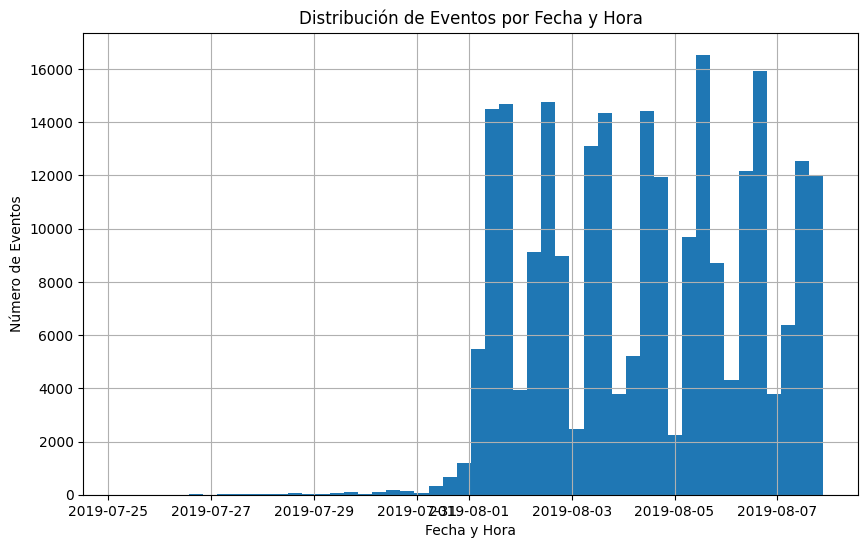

In [8]:
# Trazar un histograma por fecha y hora
plt.figure(figsize=(10, 6))
data['event_datetime'].hist(bins=50)
plt.title('Distribución de Eventos por Fecha y Hora')
plt.xlabel('Fecha y Hora')
plt.ylabel('Número de Eventos')
plt.grid(True)
plt.show()

Se puede concluir que la distribución de eventos no es uniforme a lo largo del período analizado. Existen momentos de alta actividad y otros de baja actividad.

### Verificar si los datos están completos durante todo el período.

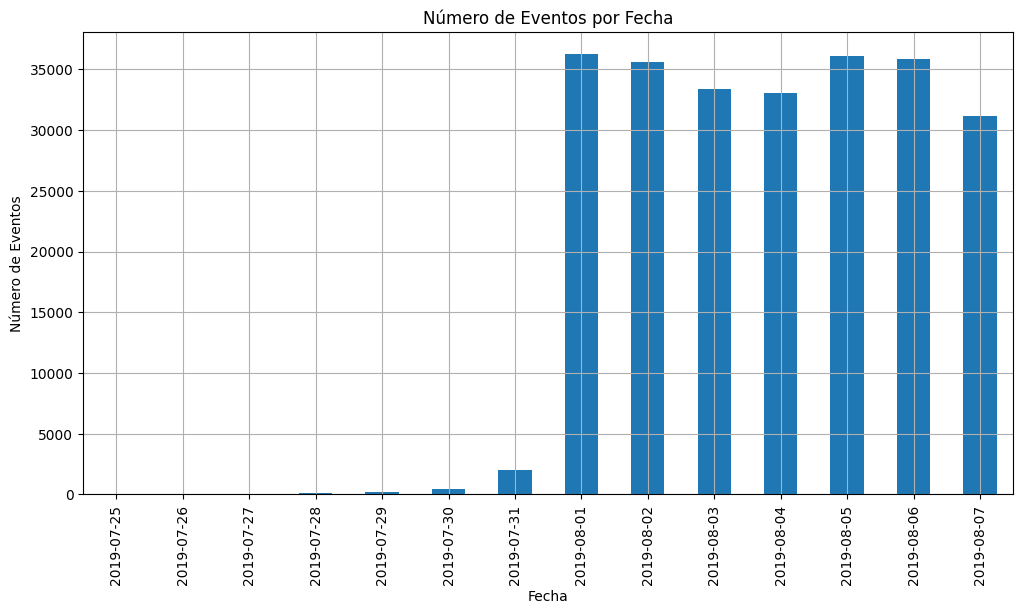

Fecha a partir de la cual los datos comienzan a estar completos: 2019-07-31


In [9]:
# Verifica si los datos están completos durante todo el período
event_counts_by_date = data['event_date'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
event_counts_by_date.plot(kind='bar')
plt.title('Número de Eventos por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Número de Eventos')
plt.grid(True)
plt.show()

# Determina la fecha en la que los datos comienzan a estar completos
cumulative_events = event_counts_by_date.cumsum() / event_counts_by_date.sum()
complete_date = cumulative_events[cumulative_events >= 0.01].index[0]
print(f"Fecha a partir de la cual los datos comienzan a estar completos: {complete_date}")

### ¿Se Perdieron muchos eventos y usuarios al excluir los datos más antiguos?

In [10]:
# Filtrar datos a partir de la fecha completa
data_filtered = data[data['event_date'] >= complete_date]

# Número de eventos y usuarios perdidos
lost_events = total_events - data_filtered.shape[0]
lost_users = unique_users - data_filtered['user_id'].nunique()

print(f"Eventos perdidos: {lost_events}")
print(f"Usuarios perdidos: {lost_users}")

Eventos perdidos: 797
Usuarios perdidos: 9


In [11]:
# Verificar la presencia de los tres grupos experimentales
exp_groups = data['exp_id'].unique()
print(f"Grupos experimentales presentes en los datos: {exp_groups}")

Grupos experimentales presentes en los datos: [246 248 247]


## Estudiar el embudo de eventos
### Frecuencia de Eventos

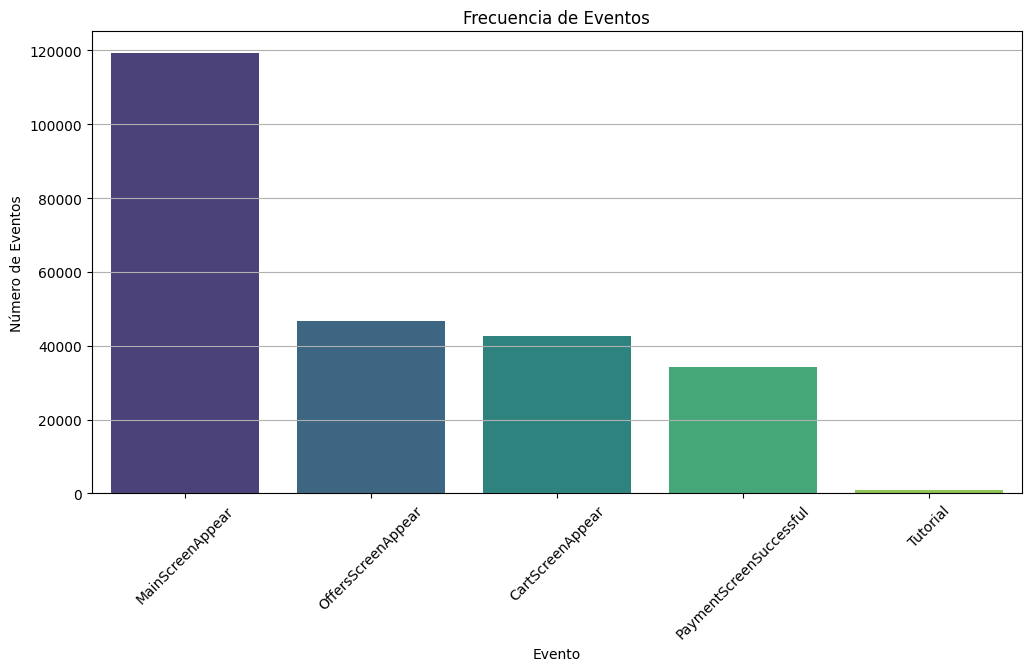

In [12]:
# Contar la frecuencia de cada evento
event_counts = data['event_name'].value_counts()

# Graficar la frecuencia de eventos
plt.figure(figsize=(12, 6))
sns.barplot(x=event_counts.index, y=event_counts.values, palette='viridis')
plt.title('Frecuencia de Eventos')
plt.xlabel('Evento')
plt.ylabel('Número de Eventos')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

- __MainScreenAppear:__ Este evento, que representa la visualización inicial de la pantalla principal, es el que ocurre con mayor frecuencia. Esto es esperable, ya que es el primer punto de contacto de los usuarios con la aplicación.
- __OffersScreenAppear:__ El segundo evento más frecuente indica que una gran cantidad de usuarios están visualizando las ofertas o promociones presentadas por la aplicación.
- __CartScreenAppear:__ El hecho de que un número considerable de usuarios llegue a la pantalla del carrito sugiere que muchos están interesados en los productos y están considerando realizar una compra.
- __PaymentScreenSuccessful:__ Este evento, que representa la finalización exitosa de una compra, es menos frecuente que los anteriores. Esto indica que aunque muchos usuarios agregan productos al carrito, no todos completan la transacción.
- __Tutorial:__ El evento Tutorial presenta la frecuencia más baja, lo que podría indicar que muchos usuarios ya están familiarizados con la aplicación y no necesitan ver el tutorial, o que el tutorial no es lo suficientemente atractivo para los usuarios.

### Número de Usuarios por Evento

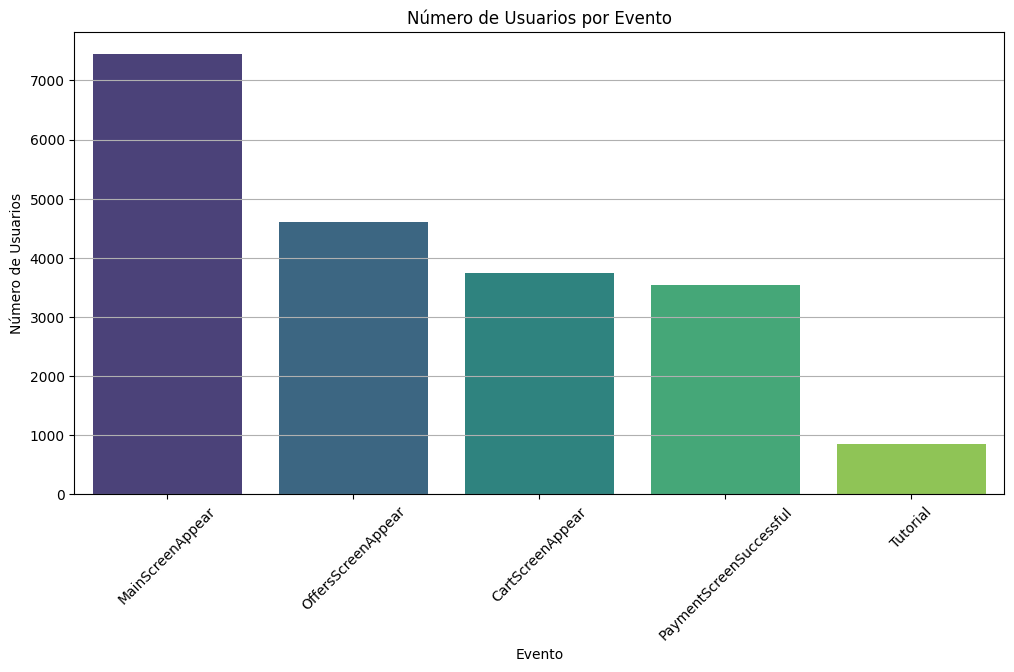

In [13]:
# Contar el número de usuarios únicos por evento
users_per_event = data.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

# Graficar número de usuarios por evento
plt.figure(figsize=(12, 6))
sns.barplot(x=users_per_event.index, y=users_per_event.values, palette='viridis')
plt.title('Número de Usuarios por Evento')
plt.xlabel('Evento')
plt.ylabel('Número de Usuarios')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### Proporción de Usuarios que Realizaron Cada Acción

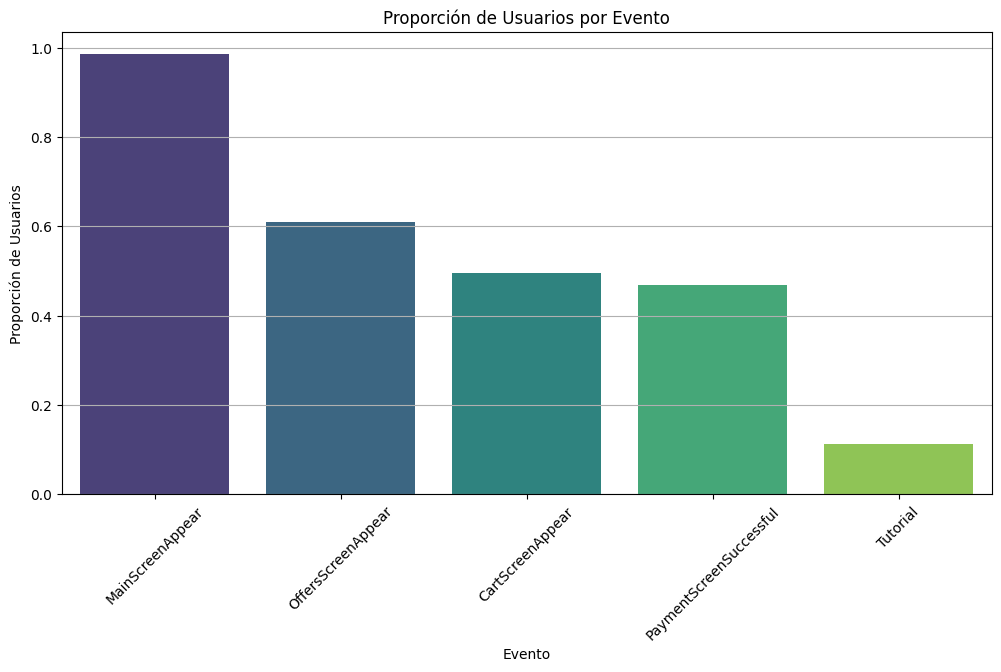

In [14]:
# Calcular la proporción de usuarios que realizaron cada acción
user_proportions = users_per_event / unique_users

# Graficar proporción de usuarios por evento
plt.figure(figsize=(12, 6))
sns.barplot(x=user_proportions.index, y=user_proportions.values, palette='viridis')
plt.title('Proporción de Usuarios por Evento')
plt.xlabel('Evento')
plt.ylabel('Proporción de Usuarios')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

- __MainScreenAppear:__ Este evento, que representa la visualización inicial de la pantalla principal, es el que ocurre con mayor frecuencia. Esto es lógico, ya que es el primer punto de contacto de los usuarios con la aplicación.
- __OffersScreenAppear:__ Un número considerable de usuarios visualiza la pantalla de ofertas, lo que indica que las promociones y descuentos son una estrategia atractiva.
- __CartScreenAppear:__ La alta frecuencia de este evento sugiere que muchos usuarios están agregando productos a sus carritos de compra, mostrando interés en adquirir productos.
- __PaymentScreenSuccessful:__ Aunque hay un número significativo de usuarios que llegan al carrito, la cantidad de usuarios que completan la compra es menor. Esto indica que existe una oportunidad para mejorar la tasa de conversión.
- __Tutorial:__ El evento Tutorial presenta la frecuencia más baja, lo que podría indicar que muchos usuarios ya están familiarizados con la aplicación y no necesitan ver el tutorial, o que el tutorial no es lo suficientemente atractivo para los usuarios.

### Proporción de Usuarios que Pasan de una Etapa a Otra

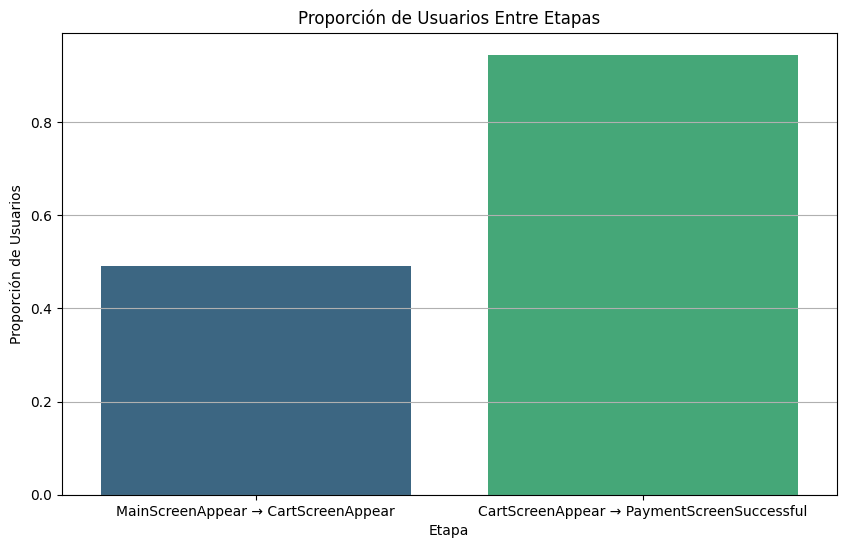

In [15]:
# Crear un DataFrame con el número de usuarios únicos en cada etapa
event_stages = {
    'MainScreenAppear': data[data['event_name'] == 'MainScreenAppear']['user_id'].unique(),
    'CartScreenAppear': data[data['event_name'] == 'CartScreenAppear']['user_id'].unique(),
    'PaymentScreenSuccessful': data[data['event_name'] == 'PaymentScreenSuccessful']['user_id'].unique()
}

# Calcular la proporción de usuarios en cada etapa
proportions = {}
for i in range(len(event_stages) - 1):
    stage_from = list(event_stages.keys())[i]
    stage_to = list(event_stages.keys())[i + 1]
    
    users_from = set(event_stages[stage_from])
    users_to = set(event_stages[stage_to])
    
    proportion = len(users_to.intersection(users_from)) / len(users_from)
    proportions[f'{stage_from} → {stage_to}'] = proportion

# Graficar proporción de usuarios entre etapas
plt.figure(figsize=(10, 6))
sns.barplot(x=list(proportions.keys()), y=list(proportions.values()), palette='viridis')
plt.title('Proporción de Usuarios Entre Etapas')
plt.xlabel('Etapa')
plt.ylabel('Proporción de Usuarios')
plt.grid(axis='y')
plt.show()

- __Alta Tasa de Añadidos al Carrito:__ La proporción de usuarios que pasan de la pantalla principal al carrito es considerablemente alta. Esto sugiere que la aplicación o sitio web está haciendo un buen trabajo en captar la atención de los usuarios y motivándolos a considerar una compra.
- __Baja Tasa de Conversión:__ A pesar de que muchos usuarios agregan productos al carrito, la proporción de aquellos que completan la compra es significativamente menor. Esto indica que existe una brecha significativa entre el interés inicial y la conversión final.

### Eventos Perdidos y Usuarios Perdidos

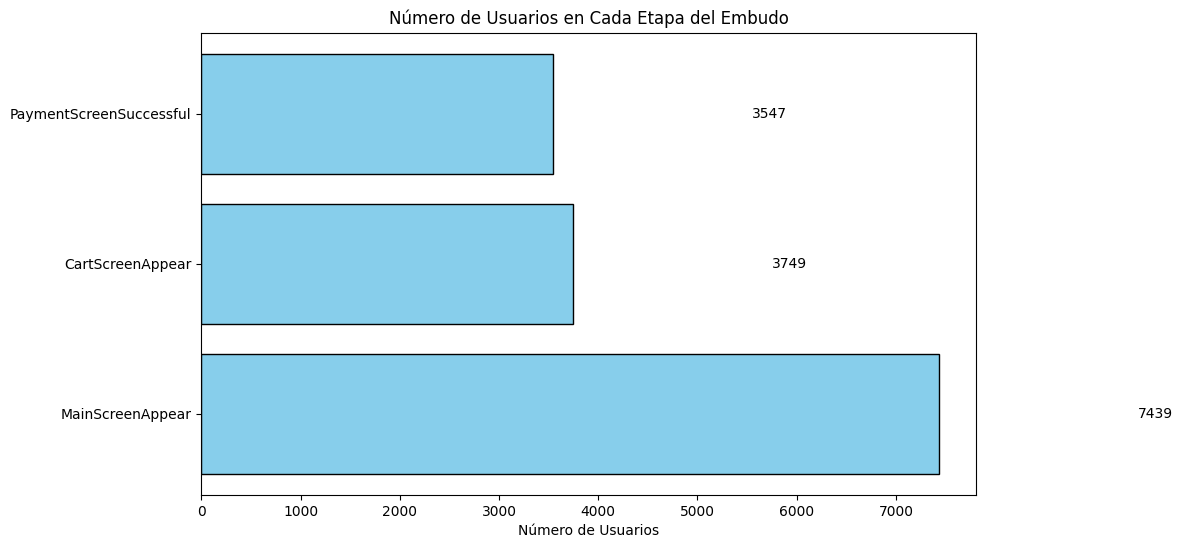

In [16]:
# Definir las etapas del embudo
stages = ['MainScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Obtener el número de usuarios únicos en cada etapa
users_by_stage = {stage: set(data[data['event_name'] == stage]['user_id'].unique()) for stage in stages}

# Contar el número de usuarios en cada etapa
users_count = [len(users_by_stage[stage]) for stage in stages]

# Calcular la pérdida de usuarios entre etapas
losses = [users_count[i] - users_count[i + 1] for i in range(len(users_count) - 1)]

# Crear el gráfico de embudo
fig, ax = plt.subplots(figsize=(10, 6))

# Definir la posición de las barras
y_pos = np.arange(len(stages))

# Graficar el número de usuarios en cada etapa
bars = ax.barh(y_pos, users_count, align='center', color='skyblue', edgecolor='black')

# Añadir etiquetas
ax.set_yticks(y_pos)
ax.set_yticklabels(stages)
ax.set_xlabel('Número de Usuarios')
ax.set_title('Número de Usuarios en Cada Etapa del Embudo')

# Mostrar las etiquetas en las barras
for bar in bars:
    width = bar.get_width()
    ax.text(width + 2000, bar.get_y() + bar.get_height()/2, f'{width}', 
            va='center', ha='left', fontsize=10, color='black')

plt.show()

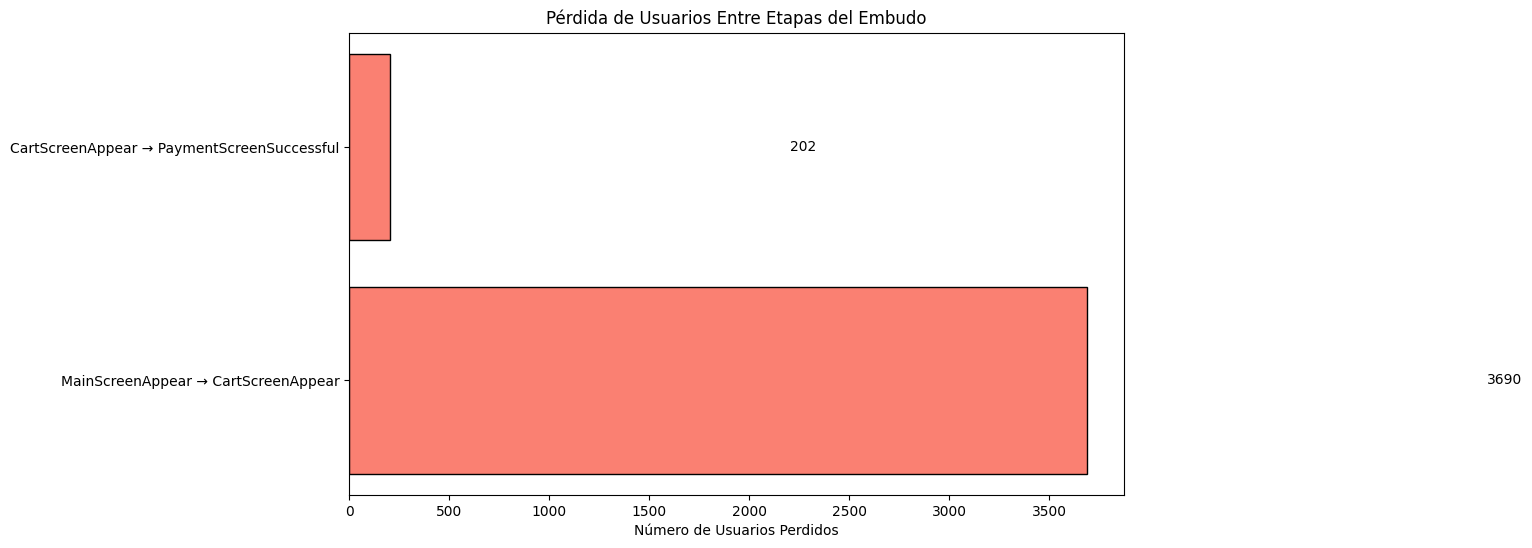

In [17]:
# Crear el gráfico de pérdidas entre etapas
fig, ax = plt.subplots(figsize=(10, 6))

# Definir las etapas de transición
transitions = [f'{stages[i]} → {stages[i + 1]}' for i in range(len(stages) - 1)]

# Graficar la pérdida de usuarios entre etapas
ax.barh(transitions, losses, align='center', color='salmon', edgecolor='black')

# Añadir etiquetas
ax.set_xlabel('Número de Usuarios Perdidos')
ax.set_title('Pérdida de Usuarios Entre Etapas del Embudo')

# Mostrar las etiquetas en las barras
for i, loss in enumerate(losses):
    ax.text(loss + 2000, i, f'{loss}', va='center', ha='left', fontsize=10, color='black')

plt.show()

### Porcentaje de usuarios que completan el viaje

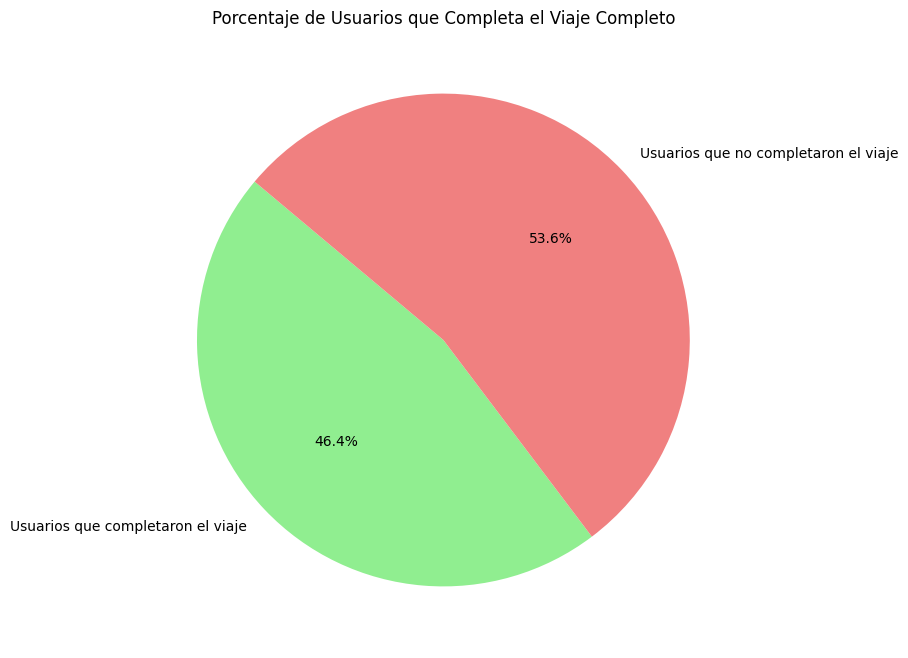

In [18]:
# Calcular el porcentaje de usuarios que completan el viaje
initial_users = users_by_stage['MainScreenAppear']
final_users = users_by_stage['PaymentScreenSuccessful']

# Usuarios que completaron el viaje
complete_journey_users = final_users.intersection(initial_users)
percentage_complete = len(complete_journey_users) / len(initial_users) * 100

# Preparar datos para el gráfico de pastel
sizes = [percentage_complete, 100 - percentage_complete]
labels = ['Usuarios que completaron el viaje', 'Usuarios que no completaron el viaje']
colors = ['lightgreen', 'lightcoral']

# Crear el gráfico de pastel
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
ax.set_title('Porcentaje de Usuarios que Completa el Viaje Completo')

plt.show()

## Estudiar los resultados del experimento
### Usuarios por grupo

In [24]:
# Número de usuarios en cada grupo
user_counts = data.groupby('exp_id')['user_id'].nunique()
print("Número de usuarios en cada grupo:")
print(user_counts)

Número de usuarios en cada grupo:
exp_id
246    2489
247    2520
248    2542
Name: user_id, dtype: int64


### Comparar los grupos de control 246 y 247

In [25]:
# Filtrar datos para los grupos de control
control_data = data[data['exp_id'].isin([246, 247])]

# Contar usuarios que realizaron el evento más popular en cada grupo de control
most_popular_event = data['event_name'].value_counts().idxmax()
event_counts = control_data[control_data['event_name'] == most_popular_event].groupby('exp_id')['user_id'].nunique()

# Crear tabla de contingencia para la prueba chi-cuadrado
contingency_table = event_counts.values.reshape(2, 1)

# Realizar la prueba chi-cuadrado
stat, p_value, _, _ = chi2_contingency(contingency_table)
print(f'Chi-cuadrado para el evento más popular: {stat}, p-valor: {p_value}')

Chi-cuadrado para el evento más popular: 0.0, p-valor: 1.0


__Hipótesis nula y alternativa:__

- __Hipótesis nula (H0):__ No hay diferencia significativa en la proporción de usuarios que realizan el evento más popular entre los grupos de control 246 y 247.
- __Hipótesis alternativa (H1):__ Existe una diferencia significativa en la proporción de usuarios que realizan el evento más popular entre los grupos de control 246 y 247.


__Decisión:__

Dado que el p-valor es 1.0, no podemos rechazar la hipótesis nula. Esto indica que no hay diferencias significativas entre los dos grupos de control para el evento más popular.

### Comparar el grupo de prueba (248) con los grupos de control

In [26]:
# Filtrar datos para el grupo de prueba
test_data = data[data['exp_id'] == 248]

# Obtener eventos en los datos de control
events_in_control = control_data['event_name'].unique()

# Comparar eventos en el grupo de prueba con los grupos de control
for event in events_in_control:
    # Contar usuarios que realizaron el evento en los grupos de control y el grupo de prueba
    control_event_counts = control_data[control_data['event_name'] == event].groupby('exp_id')['user_id'].nunique()
    test_event_count = test_data[test_data['event_name'] == event]['user_id'].nunique()
    
    if len(control_event_counts) == 2:
        # Crear tabla de contingencia para la prueba chi-cuadrado
        contingency_table = [[control_event_counts[246], control_event_counts[247]], [test_event_count, test_event_count]]
        stat, p_value, _, _ = chi2_contingency(contingency_table)
        print(f'Evento: {event}, Chi-cuadrado: {stat}, p-valor: {p_value}')

Evento: MainScreenAppear, Chi-cuadrado: 0.0587617351019528, p-valor: 0.8084638816680054
Evento: OffersScreenAppear, Chi-cuadrado: 0.02748568040157136, p-valor: 0.868323743863178
Evento: CartScreenAppear, Chi-cuadrado: 0.15503588109155497, p-valor: 0.6937686054709601
Evento: PaymentScreenSuccessful, Chi-cuadrado: 0.3393526223174485, p-valor: 0.5602031391212494
Evento: Tutorial, Chi-cuadrado: 0.022089472937114666, p-valor: 0.8818493264403614


__Hipótesis nula y alternativa:__

- __Hipótesis nula (H0):__ No hay diferencia significativa en la proporción de usuarios que realizan el evento entre el grupo de prueba (248) y los grupos de control (246 y 247).
- __Hipótesis alternativa (H1):__ Existe una diferencia significativa en la proporción de usuarios que realizan el evento entre el grupo de prueba (248) y los grupos de control (246 y 247).


__Decisión:__

Para todos los eventos analizados, los p-valores son mayores que el nivel de significación ajustado (0.02), lo que significa que no podemos rechazar la hipótesis nula en ningún caso. Esto indica que no hay diferencias significativas en el comportamiento del usuario entre el grupo de prueba y los grupos de control para los eventos analizados.

### Nivel de significación y corrección de múltiples pruebas

In [27]:
# Número total de pruebas realizadas
num_tests = len(events_in_control)

# Nivel de significación ajustado
alpha = 0.1
adjusted_alpha = alpha / num_tests
print(f'Número de pruebas realizadas: {num_tests}')
print(f'Nivel de significación ajustado: {adjusted_alpha}')

Número de pruebas realizadas: 5
Nivel de significación ajustado: 0.02


Utilizamos la corrección de Bonferroni, que es un método conservador para corregir el nivel de significación cuando se realizan múltiples pruebas estadísticas. Se ajusta el nivel de significación original (α = 0.1) dividiéndolo por el número de pruebas realizadas (en este caso, 5 eventos).

__Resultados con nivel de significación ajustado:__

Después de ajustar el nivel de significación a 0.02, observamos que todos los p-valores obtenidos en la comparación entre el grupo de prueba y los grupos de control son mayores que este valor. Por lo tanto, no hay evidencia suficiente para rechazar la hipótesis nula en ninguno de los casos.

## Concluciones

### 7. Conclusiones

#### 7.1 Resultados

- **Comparación entre los grupos de control (246 y 247):**
  - La prueba chi-cuadrado para el evento más popular arrojó un p-valor de 1.0, lo que indica que no hay diferencias significativas entre los grupos de control. Esto sugiere que los grupos de control son comparables y se dividieron correctamente.

- **Comparación entre el grupo de prueba (248) y los grupos de control (246 y 247):**
  - Para todos los eventos analizados, los p-valores son mayores que el nivel de significación ajustado de 0.02. Esto indica que no hay diferencias estadísticamente significativas entre el grupo de prueba y los grupos de control para ninguno de los eventos.

#### 7.2 Interpretación

- **Grupos de control:** No se encuentran diferencias significativas entre los grupos de control, lo que respalda que la asignación de usuarios a estos grupos fue adecuada.
  
- **Grupo de prueba:** Dado que los p-valores superan el nivel de significación ajustado, podemos concluir que el cambio de fuente no tuvo un impacto significativo en el comportamiento del usuario. Esto sugiere que el nuevo diseño no afecta negativamente la experiencia del usuario.

#### 7.3 Conclusión

El análisis sugiere que el cambio de fuente en la aplicación no provoca un cambio significativo en el comportamiento del usuario. No obstante, se recomienda considerar otros aspectos cualitativos antes de tomar una decisión final sobre la implementación del nuevo diseño.
